In [1]:
import sys, os
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *

from simulation.units import *
from simulation.population_sim import LensingObservationWithSubhalos, SubhaloPopulation

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Create simulation, enabling gradient $\nabla_{m_\mathrm{sub}}x_{ij}$ and residual computation

Text(0, 0.5, '$\\theta_y$ [arcsec]')

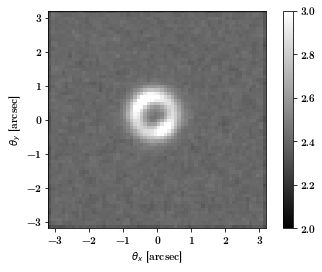

In [2]:
# Generate single lensing sample
lo = LensingObservationWithSubhalos(m_200_min_sub=1e7 * M_s, m_200_max_sub_div_M_hst=0.01,
                                        beta=-1.5, f_sub=0.05,
                                        m_min_calib=1e7 * M_s, m_max_sub_div_M_hst_calib=0.01,
                                        calculate_msub_derivatives=True,  # Enable gradient computation
                                        calculate_sub_residuals=True
)

v_min = 2.
v_max = 3.

plt.imshow(np.log10(lo.image_poiss_psf),
        vmin=v_min,
        vmax=v_max,
        cmap='gist_gray',
        extent=(-lo.coordinate_limit, lo.coordinate_limit,-lo.coordinate_limit, lo.coordinate_limit),
        origin="lower"
)
plt.colorbar()

plt.xlabel(r"$\theta_x$ [arcsec]")
plt.ylabel(r"$\theta_y$ [arcsec]")

## Residuals

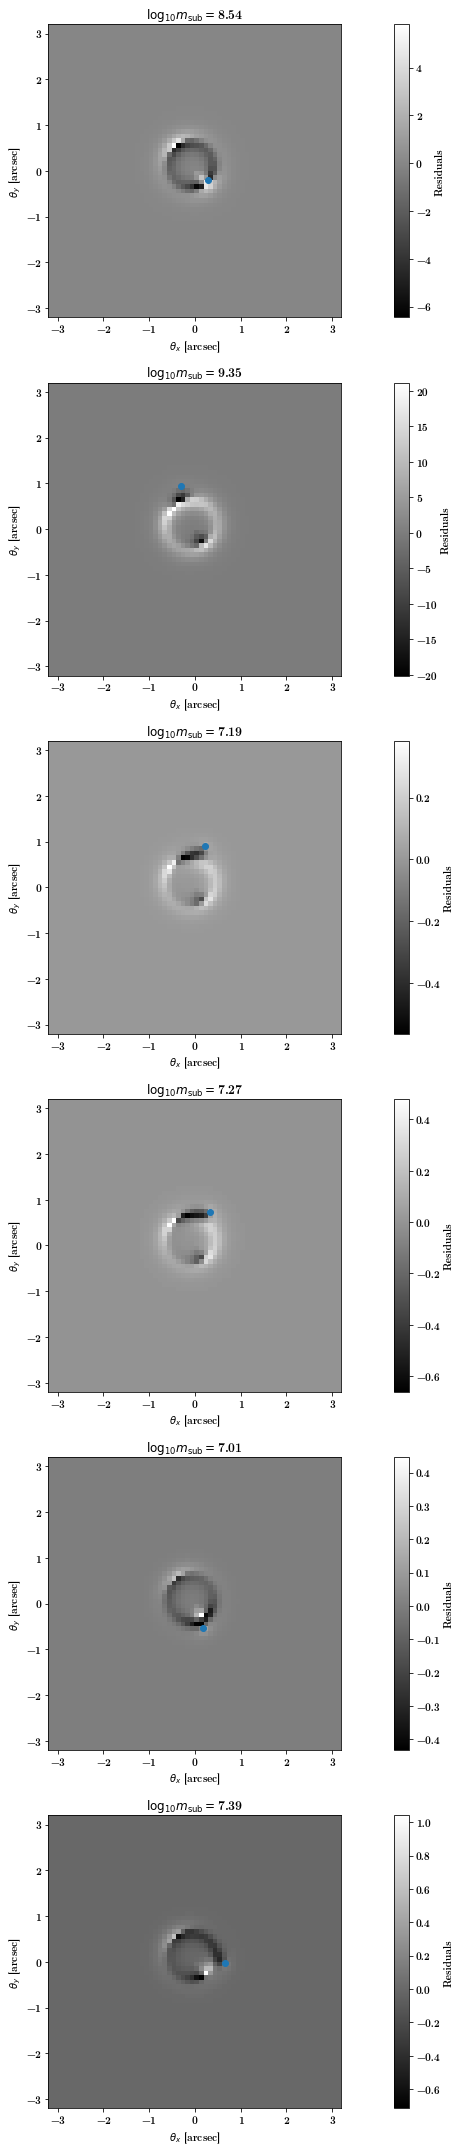

In [3]:
n_mc = lo.n_sub_roi

f, ax = plt.subplots(int(n_mc), figsize=(15, 5 * n_mc))

for i_mc in range(n_mc):
        
    im = ax[i_mc].imshow(lo.resid_sub_image[i_mc],
            cmap='gist_gray',
            extent=(-lo.coordinate_limit, lo.coordinate_limit,-lo.coordinate_limit, lo.coordinate_limit),
            origin="lower"
    )

    ax[i_mc].scatter([lo.theta_xs[i_mc]], [lo.theta_ys[i_mc]])
    plt.colorbar(im,ax=ax[i_mc], label=r"Residuals")
    
    ax[i_mc].set_title(r"$\log_{10}m_\mathrm{sub} =$" + str(np.log10(lo.m_subs[i_mc] / M_s))[:4])
    ax[i_mc].set_xlabel(r"$\theta_x$ [arcsec]")
    ax[i_mc].set_ylabel(r"$\theta_y$ [arcsec]")

plt.tight_layout()

## Checks on residuals

In [53]:
lo.n_sub_roi = 1

pos_ary = np.linspace(-3, 3, 15)
grad_ary = np.zeros((len(pos_ary), len(pos_ary)))

for i_x in tqdm(range(len(pos_ary))):
    for i_y in range(len(pos_ary)):
        m = 1e6 * M_s
        lo.theta_xs = np.array([pos_ary[i_x]])
        lo.theta_ys = np.array([pos_ary[i_y]])
        lo.m_subs = np.array([m])
        
        lo._calculate_residuals()
        grad_ary[i_x, i_y] = np.sum(np.abs(lo.resid_sub_image[0]))

100%|██████████| 15/15 [00:18<00:00,  1.44s/it]


100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


Text(0, 0.5, '$\\theta_y$ [arcsec]')

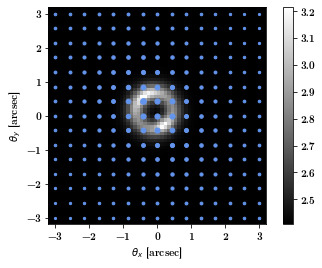

In [56]:
for i_x in tqdm(range(len(pos_ary))):
    for i_y in range(len(pos_ary)):
        plt.scatter([pos_ary[i_x]], [pos_ary[i_y]], s=10 * grad_ary[i_x, i_y], color='cornflowerblue')
        
plt.imshow(np.log10(lo._deriv_helper_function(np.array([m]))),
            cmap='gist_gray',
            extent=(-lo.coordinate_limit, lo.coordinate_limit,-lo.coordinate_limit, lo.coordinate_limit),
            origin="lower")

plt.colorbar()

plt.xlabel(r"$\theta_x$ [arcsec]")
plt.ylabel(r"$\theta_y$ [arcsec]")

## Checks on gradients

### Basic check with finite differences

16.75125427307919


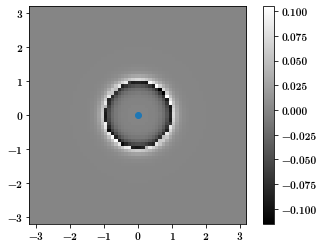

In [62]:
lo.hst_param_dict = {'profile': 'SIE',
                     'theta_x_0': 0.0,
                     'theta_y_0': 0.0,
                     'theta_E': 1.,
                     'q': 1}

lo.theta_x_0 = 0.01
lo.theta_y_0 = 0.01

lo.n_sub_roi = 1

m = 1e6 * M_s
lo.theta_xs = np.array([0.])
lo.theta_ys = np.array([0.])
lo.m_subs = np.array([m])

lo._calculate_derivs()

plt.imshow(lo.m_subs[0] * lo.grad_msub_image[0],
            cmap='gist_gray',
            extent=(-lo.coordinate_limit, lo.coordinate_limit,-lo.coordinate_limit, lo.coordinate_limit),
            origin="lower")
plt.colorbar()
plt.scatter([lo.theta_xs[0]], [lo.theta_ys[0]])

print(lo.m_subs[0] * np.sum(np.abs(lo.grad_msub_image[0])))

In [63]:
# Check that we get same answer with finite differences
dm = 1e-2 * m
deriv = (lo._deriv_helper_function(np.array([m + dm])) - lo._deriv_helper_function(np.array([m - dm]))) / (2 * dm)
np.sum(m * np.abs(deriv))

16.751287145115157

### How does gradient sum vary with mass?

In [52]:
m_ary = np.logspace(-12,14, 30) * M_s

deriv_list = []

for m in tqdm(m_ary):
    lo.hst_param_dict = {'profile': 'SIE',
                         'theta_x_0': 0.0,
                         'theta_y_0': 0.0,
                         'theta_E': 1.,
                         'q': 1}

    lo.theta_x_0 = 0.01
    lo.theta_y_0 = 0.01

    lo.n_sub_roi = 1

    lo.theta_xs = np.array([0.])
    lo.theta_ys = np.array([0.])
    lo.m_subs = np.array([m])

    lo._calculate_derivs()

    deriv_list.append(np.sum(np.abs(lo.grad_msub_image[0])))

100%|██████████| 30/30 [00:26<00:00,  1.17it/s]


Text(0, 0.5, '$\\nabla_{m_\\mathrm{sub}}x_{ij}\\,[M_\\odot^{-1}$]')

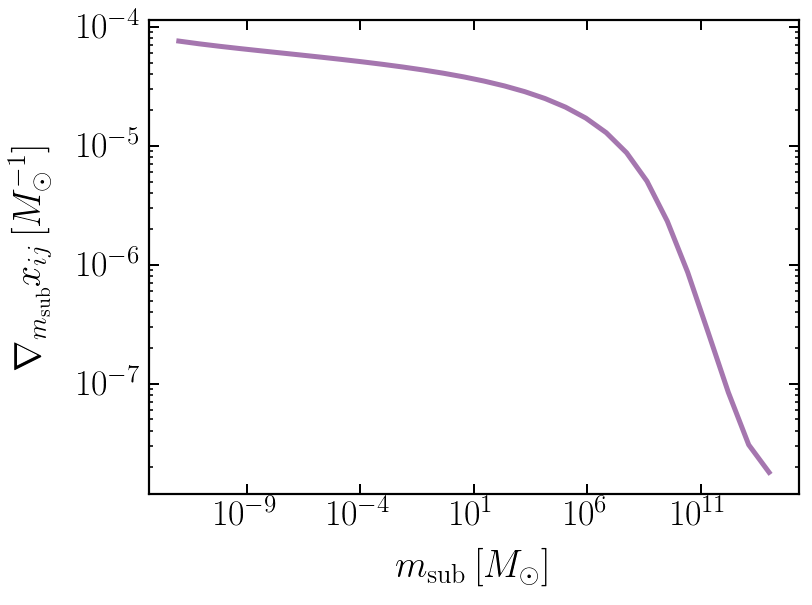

In [99]:
plt.plot(m_ary / M_s, np.array(deriv_list) * M_s)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("$m_\mathrm{sub}\,[M_\odot]$")
plt.ylabel(r"$\nabla_{m_\mathrm{sub}}x_{ij}\,[M_\odot^{-1}$]")

Text(0, 0.5, '$\\nabla_{\\log_{10} m_\\mathrm{sub}}x_{ij}$')

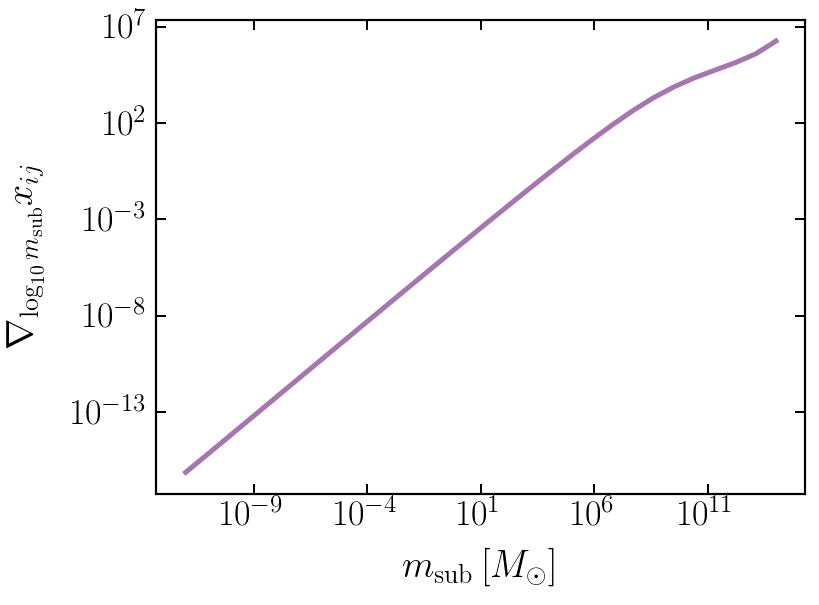

In [106]:
plt.plot(m_ary / M_s, m_ary * np.array(deriv_list))
plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$m_\mathrm{sub}\,[M_\odot]$")

plt.ylabel(r"$\nabla_{\log_{10} m_\mathrm{sub}}x_{ij}$")

### How does gradient sum vary with position?

In [78]:
pos_ary = np.linspace(-3, 3, 15)
grad_ary = np.zeros((len(pos_ary), len(pos_ary)))

for i_x in tqdm(range(len(pos_ary))):
    for i_y in range(len(pos_ary)):
        m = 1e6 * M_s
        lo.theta_xs = np.array([pos_ary[i_x]])
        lo.theta_ys = np.array([pos_ary[i_y]])
        lo.m_subs = np.array([m])

        lo._calculate_derivs()
        grad_ary[i_x, i_y] = lo.m_subs[0] * np.sum(np.abs(lo.grad_msub_image[0]))

100%|██████████| 15/15 [03:20<00:00, 13.00s/it]


100%|██████████| 15/15 [00:00<00:00, 19.63it/s]


Text(0, 0.5, '$\\theta_y$ [arcsec]')

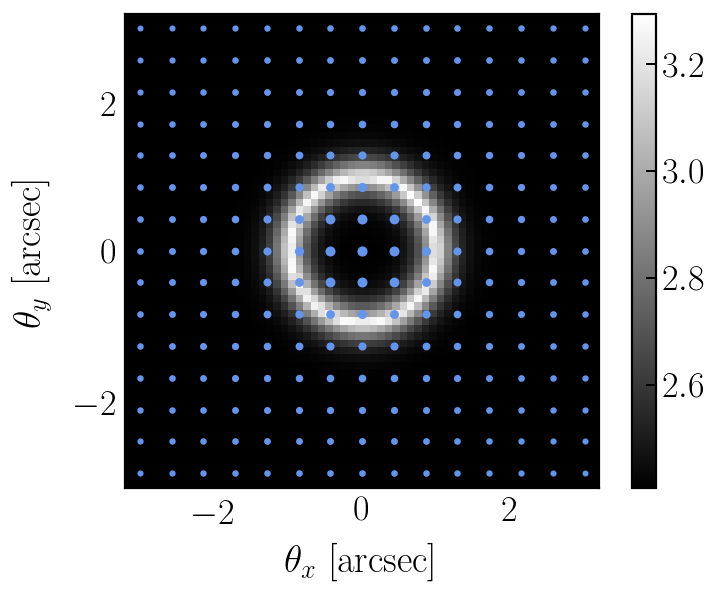

In [105]:
for i_x in tqdm(range(len(pos_ary))):
    for i_y in range(len(pos_ary)):
        plt.scatter([pos_ary[i_x]], [pos_ary[i_y]], s=grad_ary[i_x, i_y], color='cornflowerblue')
        
plt.imshow(np.log10(lo._deriv_helper_function(np.array([m]))),
            cmap='gist_gray',
            extent=(-lo.coordinate_limit, lo.coordinate_limit,-lo.coordinate_limit, lo.coordinate_limit),
            origin="lower")

plt.colorbar()

plt.xlabel(r"$\theta_x$ [arcsec]")
plt.ylabel(r"$\theta_y$ [arcsec]")

## Plot gradients

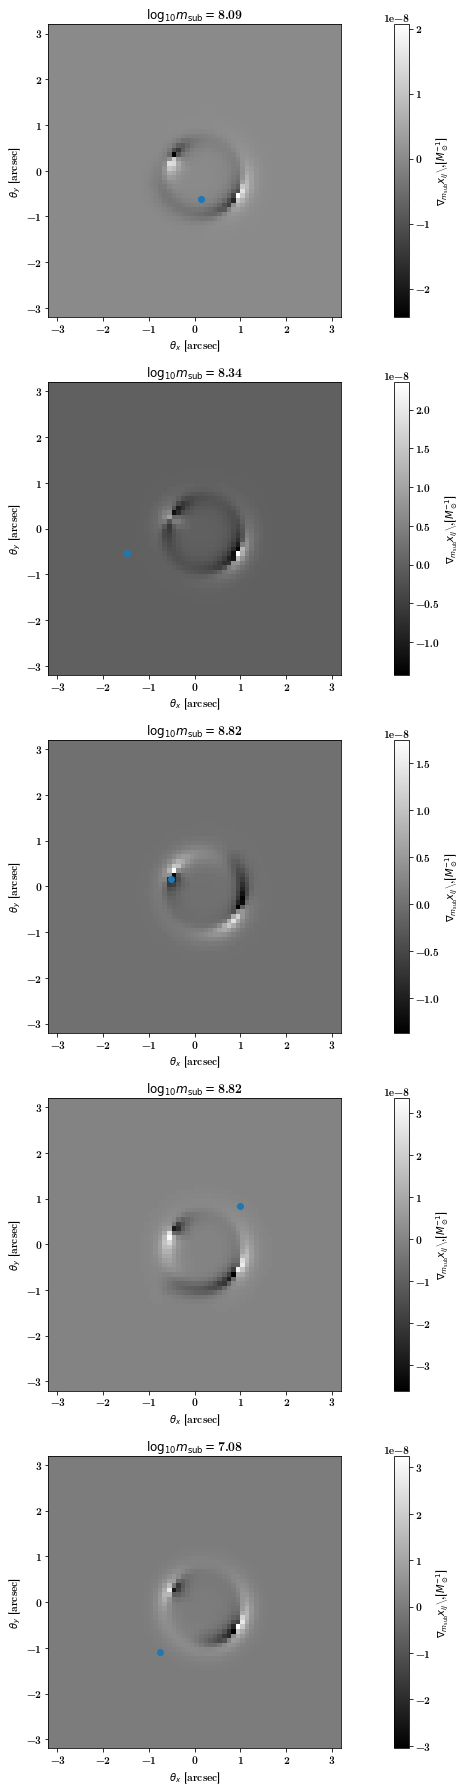

In [521]:
n_mc = lo.n_sub_roi

f, ax = plt.subplots(int(n_mc), figsize=(15, 5 * n_mc))

for i_mc in range(n_mc):
        
    im = ax[i_mc].imshow(lo.grad_msub_image[i_mc] * M_s,
            cmap='gist_gray',
            extent=(-lo.coordinate_limit, lo.coordinate_limit,-lo.coordinate_limit, lo.coordinate_limit),
            origin="lower"
    )

    ax[i_mc].scatter([lo.theta_xs[i_mc]], [lo.theta_ys[i_mc]])
    plt.colorbar(im,ax=ax[i_mc], label=r"$\nabla_{m_\mathrm{sub}}x_{ij}$\,[$M_\odot^{-1}$]")
    
    ax[i_mc].set_title(r"$\log_{10}m_\mathrm{sub} =$" + str(np.log10(lo.m_subs[i_mc] / M_s))[:4])
    ax[i_mc].set_xlabel(r"$\theta_x$ [arcsec]")
    ax[i_mc].set_ylabel(r"$\theta_y$ [arcsec]")

plt.tight_layout()